In [1]:
from tensorflow import keras
import tensorflow as tf
from keras.utils import to_categorical
import numpy as np
import os
import pickle as pkl

train_dict = pkl.load(open("../input/comp4901k/train.pkl", "rb"))
val_dict = pkl.load(open("../input/comp4901k/val.pkl", "rb"))
test_dict = pkl.load(open("../input/comp4901k/test.pkl", "rb"))

print("keys in train_dict:", train_dict.keys())
print("keys in val_dict:", val_dict.keys())
print("keys in test_dict:", test_dict.keys())

keys in train_dict: dict_keys(['id', 'word_seq', 'tag_seq'])
keys in val_dict: dict_keys(['id', 'word_seq', 'tag_seq'])
keys in test_dict: dict_keys(['id', 'word_seq'])


In [2]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Prepare the data for training

In [3]:
# prepare word vocab and tag vocab

vocab_dict = {'_unk_': 0, '_w_pad_': 1}

for doc in train_dict['word_seq']:
    for word in doc:
        if(word not in vocab_dict):
            vocab_dict[word] = len(vocab_dict)

tag_dict = {'_t_pad_': 0} # add a padding token

for tag_seq in train_dict['tag_seq']:
    for tag in tag_seq:
        if(tag not in tag_dict):
            tag_dict[tag] = len(tag_dict)
word2idx = vocab_dict
idx2word = {v:k for k,v in word2idx.items()}
tag2idx = tag_dict
idx2tag = {v:k for k,v in tag2idx.items()}            

print("size of word vocab:", len(vocab_dict), "size of tag_dict:", len(tag_dict))

size of word vocab: 82275 size of tag_dict: 65


In [4]:
# The maximum length of a sentence is set to 128
max_sent_length = 128

train_tokens = np.array([[word2idx[w] for w in doc] for doc in train_dict['word_seq']])
val_tokens = np.array([[word2idx.get(w, 0) for w in doc] for doc in val_dict['word_seq']])
test_tokens = np.array([[word2idx.get(w, 0) for w in doc] for doc in test_dict['word_seq']])


train_tags = [[tag2idx[t] for t in t_seq] for t_seq in train_dict['tag_seq']]
train_tags = np.array([to_categorical(t_seq, num_classes=len(tag_dict)) for t_seq in train_tags])

val_tags = [[tag2idx[t] for t in t_seq] for t_seq in val_dict['tag_seq']]
val_tags = np.array([to_categorical(t_seq, num_classes=len(tag_dict)) for t_seq in val_tags])

# we don't have test tags

In [5]:
# Provided function to test accuracy
# You could check the validation accuracy to select the best of your models
def calc_accuracy(preds, tags, padding_id="_t_pad_"):
    """
        Input:
            preds (np.narray): (num_data, length_sentence)
            tags  (np.narray): (num_data, length_sentence)
        Output:
            Proportion of correct prediction. The padding tokens are filtered out.
    """
    preds_flatten = preds.flatten()
    tags_flatten = tags.flatten()
    non_padding_idx = np.where(tags_flatten!=padding_id)[0]
    
    return sum(preds_flatten[non_padding_idx]==tags_flatten[non_padding_idx])/len(non_padding_idx)

from tensorflow.keras import backend as K

def accuracy(y_true, y_pred, class_to_ignore=0):
    ignore_mask = K.cast(K.not_equal(K.argmax(y_true), class_to_ignore), K.floatx())
    matches = K.cast(K.equal(K.argmax(y_true), K.argmax(y_pred)), K.floatx()) * ignore_mask
    accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
    return accuracy

# Model

In [6]:
vocab_size = len(vocab_dict)
tag_size = len(tag_dict)

with tpu_strategy.scope():
    model = keras.models.Sequential([
        keras.layers.InputLayer(input_shape=(128,)),
        keras.layers.Embedding(vocab_size, 512),
        keras.layers.Dropout(0.7),
        keras.layers.Bidirectional(keras.layers.GRU(256, return_sequences=True)),
        keras.layers.Dropout(0.6),
        keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(tag_size, activation='softmax')
    ])
    model.build(input_shape=(None, 128))

In [7]:
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 512)          42124800  
_________________________________________________________________
dropout (Dropout)            (None, 128, 512)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 512)          1182720   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 512)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128, 256)          493056    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 256)          0         
_________________________________________________________________
dense (Dense)                (None, 128, 65)           1

In [8]:
with tpu_strategy.scope():
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(learning_rate=0.01, decay=0.02), 
                  metrics=[accuracy])

In [9]:
num_epochs = 300

history = model.fit(train_tokens, 
                    train_tags, 
                    epochs=num_epochs, 
                    batch_size=2048,
                    validation_data=(val_tokens, val_tags), 
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)]
                    )

Epoch 1/300
12/12 [==============================] - 13s 1s/step - accuracy: 0.6448 - loss: 2.2643 - val_accuracy: 0.7552 - val_loss: 1.1744
Epoch 2/300
12/12 [==============================] - 3s 286ms/step - accuracy: 0.7476 - loss: 1.2289 - val_accuracy: 0.7523 - val_loss: 0.9645
Epoch 3/300
12/12 [==============================] - 4s 334ms/step - accuracy: 0.7519 - loss: 0.9980 - val_accuracy: 0.7647 - val_loss: 0.8410
Epoch 4/300
12/12 [==============================] - 4s 335ms/step - accuracy: 0.7668 - loss: 0.8735 - val_accuracy: 0.7812 - val_loss: 0.7754
Epoch 5/300
12/12 [==============================] - 4s 325ms/step - accuracy: 0.7821 - loss: 0.8030 - val_accuracy: 0.7881 - val_loss: 0.7262
Epoch 6/300
12/12 [==============================] - 4s 331ms/step - accuracy: 0.7931 - loss: 0.7476 - val_accuracy: 0.8043 - val_loss: 0.6840
Epoch 7/300
12/12 [==============================] - 4s 324ms/step - accuracy: 0.8048 - loss: 0.7023 - val_accuracy: 0.8149 - val_loss: 0.6483
E

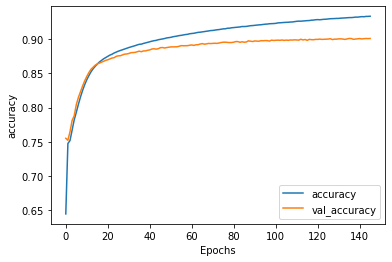

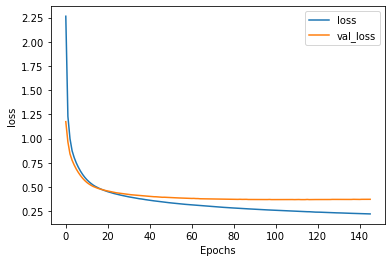

In [10]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [11]:
val_result = model.predict([val_tokens])
val_result = val_result[0:len(val_tokens)]
val_result = val_result.argmax(axis = -1)
val_result = np.vectorize(lambda idx: idx2tag[idx])(val_result)
calc_accuracy(val_result, np.array(val_dict['tag_seq']))

0.8999768578784461

In [12]:
test_result = model.predict([test_tokens])
test_result = test_result[0:len(test_tokens)]
test_result = test_result.argmax(axis = -1)
test_result = np.vectorize(lambda idx: idx2tag[idx])(test_result)

In [13]:
import json
import pandas as pd

df = pd.DataFrame({'id': test_dict["id"],
                   'labels': [json.dumps(np.array(preds).tolist()) for preds in test_result]})
df.to_csv('test_preds.csv', index=False)

df = pd.DataFrame({'id': val_dict["id"],
                   'labels': [json.dumps(np.array(preds).tolist()) for preds in val_result]})
df.to_csv('val_preds.csv', index=False)